<a href="https://colab.research.google.com/github/snapthat/TF-T5-text-to-text/blob/master/snapthatT5/notebooks/TF-T5-%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href= "https://www.snapthat.ai/"> <img src="https://www.snapthat.ai/img/landing/images/logo_h1.png" /></a>

## Training T5 using Native Tensorflow 2

The purpose of this notebook is to demonstrate training using tensorflow 2 and keras. This notebook includes tf Data pipelines for build any other NLP task in a text to text fashion. Anyone can adapt the data pipeline to thier own datasets for Text-2-Text fashion training.
#### Features
- Train TF T5 on SQUAD questioning and answering
- Train T5 using keras trainer fucntion
- tf.Data pipeline
- TF datasets as source
- Log metrics using tensorboard
- Profile your experiment with the brand new tensorflow profiler !!

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from transformers import (TFAutoModelWithLMHead, AutoTokenizer, 
    TFTrainer, TFTrainingArguments, TFT5ForConditionalGeneration, T5Config)
import datetime
import os

In [2]:
os.environ["TF_GPU_THREAD_MODE"]="gpu_private"

In [3]:
tf.__version__

'2.3.1'

In [4]:
data_dir = "/home/ml/workspace/ai/TF-T5-text-to-text/data"

log_dir = f"{data_dir}/experiments/t5/logs"
save_path = f"{data_dir}/experiments/t5/models"
cache_path_train = f"{data_dir}/cache/t5.train"
cache_path_test = f"{data_dir}/cache/t5.test"

### Defining the Model

In [5]:
class SnapthatT5(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss') 
    
    @tf.function
    def train_step(self, data):
        x, y  = data
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
#         lr = lr if tf.is_tensor(optimizer.lr) else optimzer.lr(optimizer.)
        
        self.loss_tracker.update_state(loss)
        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x, y = data
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}

        

### The Tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")          

## Preparing the Data

In [7]:
train_dataset, info = tfds.load('squad', split='train', with_info=True)
valid_dataset = tfds.load('squad', split='validation', with_info=False)
print(info)

INFO:absl:No config specified, defaulting to first: squad/plain_text
INFO:absl:Load dataset info from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0
INFO:absl:Reusing dataset squad (/home/ml/tensorflow_datasets/squad/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0
INFO:absl:No config specified, defaulting to first: squad/plain_text
INFO:absl:Load dataset info from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0
INFO:absl:Reusing dataset squad (/home/ml/tensorflow_datasets/squad/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from /home/ml/tensorflow_datasets/squad/plain_text/1.0.0


tfds.core.DatasetInfo(
    name='squad',
    version=1.0.0,
    description='Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.',
    homepage='https://rajpurkar.github.io/SQuAD-explorer/',
    features=FeaturesDict({
        'answers': Sequence({
            'answer_start': tf.int32,
            'text': Text(shape=(), dtype=tf.string),
        }),
        'context': Text(shape=(), dtype=tf.string),
        'id': tf.string,
        'question': Text(shape=(), dtype=tf.string),
        'title': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=98169,
    splits={
        'train': 87599,
        'validation': 10570,
    },
    supervised_keys=None,
    citation="""@article{2016arXiv160605250R,
           author = {{Rajpurkar}, 

In [8]:
data = next(iter(train_dataset))
print("Example data from the dataset: \n", data)

Example data from the dataset: 
 {'answers': {'answer_start': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([427], dtype=int32)>, 'text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'mobile phones'], dtype=object)>}, 'context': <tf.Tensor: shape=(), dtype=string, numpy=b'The difference in the above factors for the case of \xce\xb8=0 is the reason that most broadcasting (transmissions intended for the public) uses vertical polarization. For receivers near the ground, horizontally polarized transmissions suffer cancellation. For best reception the receiving antennas for these signals are likewise vertically polarized. In some applications where the receiving antenna must work in any position, as in mobile phones, the base station antennas use mixed polarization, such as linear polarization at an angle (with both vertical and horizontal components) or circular polarization.'>, 'id': <tf.Tensor: shape=(), dtype=string, numpy=b'57306bf68ab72b1400f9c4dc'>, 'question': <tf.Tensor: 

#### Training Parameters

In [9]:
warmup_steps = 1e4
batch_size = 4
max_len = 100
buffer_size = 1000
ntrain = info.splits["train"].num_examples
nvalid = info.splits["validation"].num_examples
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))
print("Total Steps: ", steps)
print("Total Validation Steps: ", valid_steps)

Total Steps:  21900
Total Validation Steps:  2643


### Defining the data pipeline

In [10]:
def encode(context,question ,answer, max_length=max_len):
    question_plus = f"answer_me: {str(question.numpy().decode('utf-8'))}"
    question_plus += f" context: {str(context.numpy().decode('utf-8'))}  </s>"
    
    answer_plus = ', '.join([i.decode('utf-8') for i in list(answer.numpy())])
    answer_plus = f"{answer_plus} </s>"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=max_length,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=max_length,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    return input_ids,input_attention, target_ids, target_attention
    
    

In [11]:
def encode_tf(inputs):
    context = inputs['context']
    question = inputs['question']
    answer = inputs['answers']['text']
    encoded = tf.py_function(encode, [context, question, answer], 
                                           [tf.int32, tf.int32, tf.int32, tf.int32])
    input_ids,input_attention, target_ids,target_attention = encoded
    input_ids.set_shape([None])
    target_ids.set_shape([None])
    input_attention.set_shape([None])
    target_attention.set_shape([None])
    
    labels = tf.reshape(target_ids, [-1, 1])
    data=  {'input_ids': input_ids, #'decoder_input_ids': target_ids, 
            'labels': target_ids, 
            'attention_mask': input_attention,
           'decoder_attention_mask': target_attention}
    return (data, labels)


In [12]:
def create_dataset(source_dataset, cache_path=None, batch_size=4, 
                   buffer_size= 1000, shuffling=True):
    dataset = source_dataset.map(encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    

In [13]:
train_ds= create_dataset(train_dataset, batch_size=batch_size, 
                         shuffling=True, cache_path = None)
valid_ds = create_dataset(valid_dataset, batch_size=batch_size, 
                         shuffling=False, cache_path = None)


In [14]:
data = next(iter(train_ds))
data

/home/ml/anaconda3/envs/hugging/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1768: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


({'input_ids': <tf.Tensor: shape=(4, 100), dtype=int32, numpy=
  array([[ 1525,   834,   526,    10,   571,   231,    47,     8,     3,
          15829,  6878,    53,  1154,    28,     8,  6552,  3815,  1494,
             16,  1230,    58,  2625,    10,    37,  6552,  3815,    19,
           6878,    16,     8,   907,  1323,   190,     3, 15829,  5716,
              5,  6552,  3815, 17831,  2009,    65,  1936,  7313,     6,
             28,     3, 15829,    11,     3, 15829,  8544,     3,     9,
          23980,     3,     9,  1368, 10635, 23938, 13569,    16,     8,
           1412,   104,  1808,   774,     6,    95,   850,  5953,    45,
           1673,   104,  2368,   116,  2591,   341,     3,  2378,    26,
             30,  7547, 23375,    11, 25043,    87, 26130,   567,   357,
           4743, 13922, 13569,   201,    11,     3, 15829,  5716,    65,
            118],
         [ 1525,   834,   526,    10,  4073,  3262,  8996,    16, 26660,
             19,   801,    12,    36,     3

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, warmup_steps=1e4, schedule=True, initial_lr = 1e-3):
    super().__init__()

    self.warmup_steps = tf.cast(warmup_steps, tf.float32)
    
  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    m = tf.maximum(self.warmup_steps, step)
    m = tf.cast(m, tf.float32)
    lr = tf.math.rsqrt(m)
    
    return lr 
        

Text(0, 0.5, 'Learning rate')

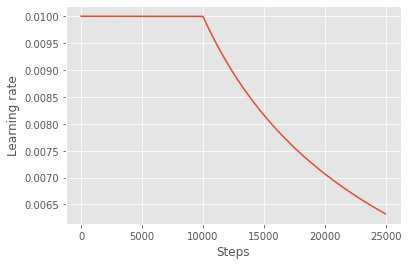

In [17]:
plt.style.use('ggplot')
schedule = CustomSchedule()
plt.plot(schedule(tf.range(25000, dtype=tf.float32)))
plt.xlabel("Steps")
plt.ylabel("Learning rate")

### Callbacks

In [18]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_path + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback] 
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy') ]

In [19]:
learning_rate = CustomSchedule()
# learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [20]:
model = SnapthatT5.from_pretrained("t5-base")


You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.compile(optimizer=optimizer, metrics=metrics)

In [22]:
epochs_done = 0
model.fit(train_ds, epochs=50, steps_per_epoch=steps, callbacks=callbacks, 
          validation_data=valid_ds, validation_steps=valid_steps, initial_epoch=epochs_done)

Epoch 1/50


/home/ml/anaconda3/envs/hugging/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ml/anaconda3/envs/hugging/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1768: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


21900/21900 [==============================] - 9771s 446ms/step - accuracy: 0.9571 - loss: 0.4131 - lr: 0.0089 - val_accuracy: 0.8610 - val_loss: 1.3091
Epoch 2/50
  109/21900 [..............................] - ETA: 2:36:47 - accuracy: 0.9571 - loss: 0.4001 - lr: 0.0067WARNING:tensorflow:From /home/ml/anaconda3/envs/hugging/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


 8291/21900 [==========>...................] - ETA: 1:38:46 - accuracy: 0.9575 - loss: 0.4015 - lr: 0.0062

KeyboardInterrupt: 

In [ ]:
# model.evaluate(valid_ds, steps=valid_steps)

In [23]:
model.save_pretrained(save_path)


### Lets tests our model!!

In [28]:
context = """We went on a trip to Europe. We had our breakfast at 7 am in the morning at \
the nearby coffee shop. Wore a dark blue over coat for our first visit to Louvre Museum \
to experience history and art."""

question = "At what time did we had breakfast?"
print(context)
print(question)

We went on a trip to Europe. We had our breakfast at 7 am in the morning at the nearby coffee shop. Wore a dark blue over coat for our first visit to Louvre Museum to experience history and art
At what time did we had breakfast?


In [29]:
input_text =  f"answer_me: {question} context: {context} </s>"
encoded_query = tokenizer(input_text, 
                         return_tensors='tf', padding=True, truncation=True)
input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]
generated_question = model.generate(input_ids, attention_mask=attention_mask)
decoded_question = tokenizer.decode(generated_question.numpy()[0])

In [30]:
decoded_question

'a'